In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import pandas as pd
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn import linear_model 
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.linear_model import ElasticNet
# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_49348/13218494.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Read data from txt file, headers have spaces in them..
data = pd.read_csv('case1Data.txt', sep=",")

# Explorative data analysis

## Training data

In [7]:
print("Shape", data.shape)
# convert datatypes
data = data.apply(lambda x: x.astype('float64') if 'x' in x.name else x)
data = data.apply(lambda x: x.astype('category') if 'C' in x.name else x)
data.columns = data.columns.str.replace(' ', '')
features = [x for x in data.columns if x != 'y']   
numerical_features = data[features].select_dtypes(include=['float64']).columns
categorical_features = data[features].select_dtypes(include=['category']).columns
data.head()

Shape (100, 101)


,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


In [4]:
data.describe()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95
count,100.000000,84.000000,87.000000,81.000000,82.000000,85.000000,91.000000,89.000000,85.000000,87.000000,...,84.000000,92.000000,86.000000,88.000000,83.000000,79.000000,87.000000,87.000000,85.000000,90.000000
mean,-9.449225,24.152278,11.535373,-9.744737,-4.060555,-16.392856,-2.810344,-38.684160,15.323868,-4.836150,...,17.637259,0.652821,12.151878,-7.467135,-8.040902,-14.477416,4.552843,-16.015159,23.371891,-13.343786
std,54.637475,3.226483,2.616437,3.201830,2.605455,2.820285,2.946260,2.235738,3.036549,2.825773,...,2.747872,3.001337,3.026242,2.808379,2.672240,3.087054,2.670058,2.759980,2.781380,3.125821
min,-178.046246,16.031508,4.278967,-16.157991,-10.456794,-24.271015,-10.201020,-43.827753,8.435083,-11.078308,...,11.211716,-6.232716,4.481362,-13.284533,-16.702016,-21.322369,-1.395252,-21.761067,16.877332,-19.410096
25%,-44.109740,21.718763,9.735326,-11.824124,-5.868863,-17.906581,-4.655860,-40.320246,12.998737,-6.770507,...,15.798499,-1.607624,10.239859,-9.517063,-9.918741,-16.347168,2.560855,-17.887639,21.474290,-15.972494
50%,-5.108532,24.039863,11.204954,-9.711051,-3.823393,-16.290923,-2.431349,-38.787664,15.739363,-4.969147,...,17.573367,0.636956,12.737008,-6.902784,-8.000845,-14.268092,4.749562,-16.170375,23.697288,-12.975518
75%,24.499702,26.422000,13.360494,-7.684899,-2.458013,-14.732024,-0.953774,-37.246405,17.485969,-2.585693,...,19.409453,2.920330,13.810049,-5.718319,-5.983640,-13.100169,6.476377,-14.151908,25.497565,-11.206957
max,113.446867,31.991717,18.573992,-1.861803,2.531620,-9.921926,4.792236,-31.823017,24.255647,1.294652,...,24.234257,6.492363,19.442490,-0.294956,-1.973244,-6.163989,10.183673,-8.911256,29.450024,-6.630455


#### Missing values
* Lots of them, how to handle?
* Assume they are missing at random
* Deletion, imputation or model based?
* Deletion: Will lose too much information
* Imputation: Perhaps, but chose carefully. Look at histogram of each feature for continous. For categorical, consider just making NaN into a category in itself, or remove?
* SciKit Learns IterativeImputation seem to be working very well and catches trends in data while keeping the same overall summary statistics.

In [ ]:
# Count plot of variables with missing values
missing = data.isnull().sum()
missing = missing[missing > 0]
print("Number of features with missing values =", missing.shape[0])
print("Total number of missing values =", missing.sum())
missing.sort_values(inplace=True)
plt.figure(figsize=(20, 5))
plt.title("Number of missing values in each feature")
plt.xlabel("Feature name")
plt.ylabel("Number of missing values")
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.savefig('Plots/train_num_missing_values.png')
plt.show()

In [ ]:
# histogram of each feature with missing values
plt.figure(figsize=(20, 20))
for i, feature in enumerate(features):
    plt.subplot(10, 10, i+1)
    plt.title(feature)
    sns.histplot(data[feature], kde=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.savefig('Plots/train_histograms.png')
plt.show()

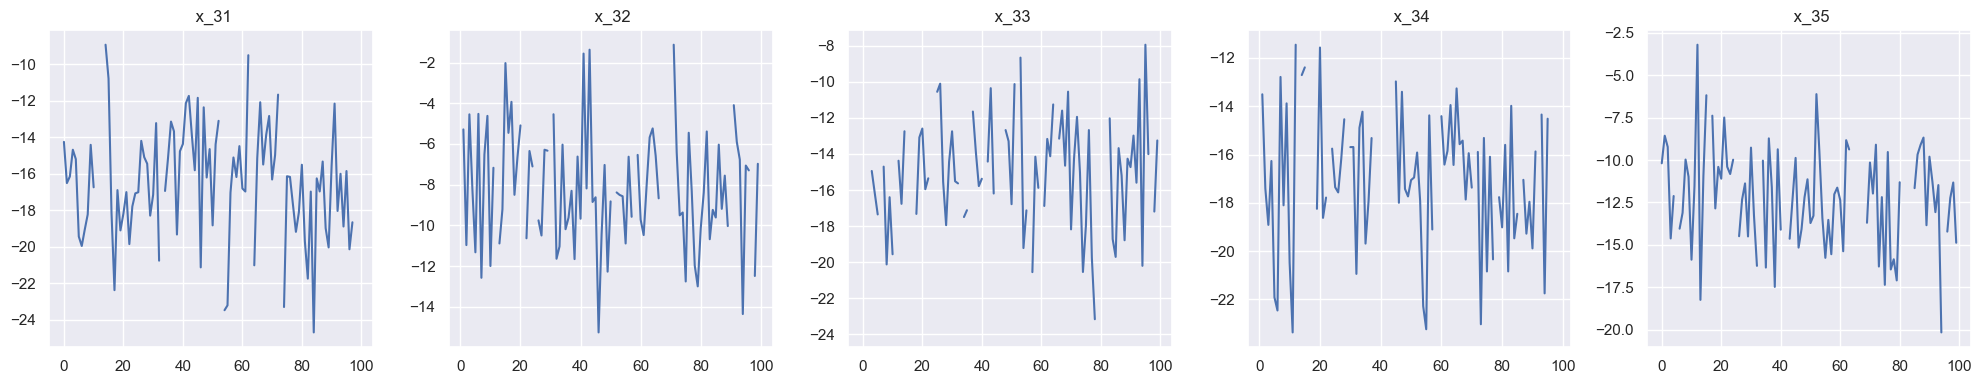

In [14]:
# Visualize development of each numerical feature over time in one plot
plt.figure(figsize=(20, 4))
for i, feature in enumerate(features[30:35]):
    plt.subplot(1, 5, i+1)
    plt.title(feature)
    plt.plot(data[feature])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.savefig('Plots/missing_5.png')
plt.show()

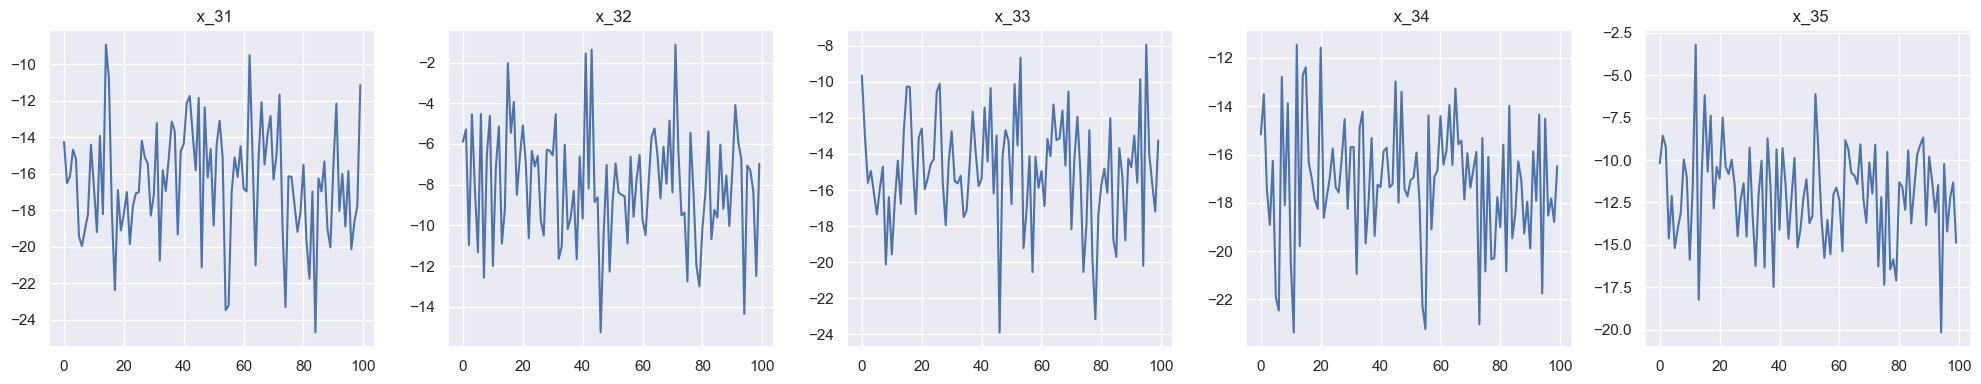

In [15]:
imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed = data.copy()
feature_30_to_35 = numerical_features[30:35]
data_imputed[feature_30_to_35] = imputer.fit_transform(data[feature_30_to_35])

# plot the data after imputation
plt.figure(figsize=(20, 4))
for i, feature in enumerate(features[30:35]):
    plt.subplot(1, 5, i+1)
    plt.title(feature)
    plt.plot(data_imputed[feature])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.savefig('Plots/imputed_5.png')
plt.show()

In [ ]:
# Visualize development of each numerical feature over time in one plot
plt.figure(figsize=(20, 40))
for i, feature in enumerate(features):
    plt.subplot(20, 5, i+1)
    plt.title(feature)
    plt.plot(data[feature])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
#plt.savefig('Plots/train_development_missing_values.png')
plt.show()

In [ ]:
# Impute missing values for numerical features with interpolation
imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed = data.copy()
data_imputed[numerical_features] = imputer.fit_transform(data[numerical_features])

# plot the data after imputation
plt.figure(figsize=(20, 40))
for i, feature in enumerate(features):
    plt.subplot(20, 5, i+1)
    plt.title(feature)
    plt.plot(data_imputed[feature])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.savefig('Plots/train_development_iterative_imputation.png')
plt.show()

#### Exploration of target variable

In [ ]:
# Development of y over time
plt.figure(figsize=(20, 5))
plt.title("Development of y")
plt.xlabel("Observation")
plt.ylabel("Value of y")
sns.lineplot(x=data.index, y=data.y)
# min and max
plt.text(data.y.idxmax(), data.y.max(), f'Max: {round(data.y.max(),2)}', c = 'r')
plt.text(data.y.idxmin(), data.y.min(), f'Min: {round(data.y.min(),2)}', c = 'r')
# mean and median
plt.axhline(data.y.mean(), color='r', linestyle='--', label='Mean')
plt.text(-5, data.y.mean()-14, f'Mean: {round(data.y.mean(),2)}', c = 'r')
plt.axhline(data.y.median(), color='g', linestyle='--', label='Median')
plt.text(-5, data.y.median()+4, f'Median: {round(data.y.median(),2)}', c = 'g')
plt.legend()
plt.savefig('Plots/train_y_development.png')
plt.show()

#### Feature selection
* How to handle numerical vs categorical features? 1-hot encode categorical features perhaps?
* Which techniques to use?
* Regularization, Ridge Regression, Shrink parameters. How to chose optimal Lambda value? 
* Ragularization, Lasso Regression, Remove parameters. How to chose optimal Lambda value? 
* **Elastic net, mix of the 2 above.** How to chose optimal lambda and alpha values?
* Forward vs Backward Selection
* Clustering of features
* PCA
* Feature assessment, Bonferroni Correction, FDR, Benjamini Hochbergs.

In [ ]:
# correlation analysis
data_num = data.select_dtypes(include=['float64'])
corr = data_num.corr()
# sort corr by y
corr = corr.sort_values(by='y', ascending=False)
# barplot of correlation with y
plt.figure(figsize=(20, 5))
plt.title("Correlation with y")
plt.xlabel("Feature name")
plt.ylabel("Correlation with y")
sns.barplot(x=corr.index, y=corr.y, hue=corr.y, dodge=False)
plt.legend(loc='upper right', title='Correlation with y')
plt.xticks(rotation=90)
plt.savefig('Plots/train_correlation_y.png')
plt.show()

In [ ]:
# filter top 20 correlated features with y
top20_corr = corr.y[1:21]
# plot the correlation matrix between these features
plt.figure(figsize=(20, 12))
plt.title("Correlation matrix of top 20 features correlated with y")
sns.heatmap(data_num[top20_corr.index].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('Plots/train_correlation_matrix_top20.png')
plt.show()

In [ ]:
# scatter plot of y with top 20 correlated features in 5x4 subplot
plt.figure(figsize=(20, 12))
plt.suptitle("Scatter plot of y with top 20 correlated features")
for i, col in enumerate(top20_corr.index):
    plt.subplot(5, 4, i+1)
    sns.scatterplot(x=data[col], y=data.y)
    plt.title(f"y vs {col}")
    # fit line
    sns.regplot(x=data[col], y=data.y, scatter=False)
plt.tight_layout()
plt.savefig('Plots/train_scatter_with_y_top20.png')
plt.show()

In [ ]:
data_cat = data.select_dtypes(include=['category'])
# subplot for each categorical variable, countplot of y
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 8))
fig.suptitle("Countplot of y for each categorical variable")
for i, ax in enumerate(axes.flatten()):
    if i < data_cat.shape[1]:
        sns.countplot(x=data_cat.iloc[:, i], ax=ax)
        ax.set_title(data_cat.columns[i])
        ax.set_xlabel("Value")
        ax.set_ylabel("Y count")
    else:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()

## Final Model
* Onehot encoding of categorical features
* Cross validation
* Imputation and standardization inside each CV fold
* Model selection: Aplha and L1 for Elastic Net
* Then Apply model with CV using optimal values
* R^2, RMSE

In [8]:
# Data preperation (one-hot encoding)
def train_preprocessing(data):
    NaN_array = np.zeros(100)

    # Perform one-hot encoding for categorical variables
    one_hot_encoded = pd.get_dummies(data[categorical_features], drop_first=False, dummy_na=False, dtype=int)
    one_hot_encoded.insert(7, "C_2_NaN", NaN_array, True)
    one_hot_encoded.insert(13, "C_3_NaN", NaN_array, True)
    one_hot_encoded.insert(19, "C_4_NaN", NaN_array, True)
    one_hot_encoded.insert(25, "C_5_NaN", NaN_array, True)
    # convert all one-hot encoded columns to int
    one_hot_encoded = one_hot_encoded.astype(int)

    # Drop the original categorical columns from the DataFrame
    df_numerical = data.drop(columns=categorical_features)

    # Concatenate the one-hot encoded columns with the original DataFrame
    data_encoded = pd.concat([df_numerical, one_hot_encoded], axis=1)
    data_encoded.columns = data_encoded.columns.str.replace(' ', '')
    return data_encoded

In [38]:
def model_selection(X, y):
    # Cross Validation
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)

    alphas = np.linspace(0, 4, num=20)
    l1_ratios = np.linspace(0, 1, num=20)
    mse = np.zeros((folds,len(l1_ratios),len(alphas)))

    features_num = [x for x in X.columns if x.startswith('x')]
    features_cat = [x for x in X.columns if x.startswith('C')]
    # Iterate over each fold and chose the alpha and l1_ratio that gives the lowest average MSE
    for k, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Impute missing values
        # Standardize the data, only numerical features
        x_train_mean = X_train.iloc[:, :len(features_num)].mean(axis=0)
        x_train_std = X_train.iloc[:, :len(features_num)].std(axis=0)
        X_train.iloc[:, :len(features_num)] = (X_train.iloc[:, :len(features_num)] - x_train_mean) / x_train_std
        X_val.iloc[:, :len(features_num)] = (X_val.iloc[:, :len(features_num)] - x_train_mean) / x_train_std
        
        imputer = IterativeImputer(max_iter=10, random_state=0)
        X_train[features_num] = imputer.fit_transform(X_train[features_num])
        X_val[features_num] = imputer.transform(X_val[features_num])
        # Model selection
        for i, alpha in enumerate(alphas):
            for j, l1_ratio in enumerate(l1_ratios):
                with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
                    warnings.simplefilter("ignore")
                    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    mse[k,i,j] = mean_squared_error(y_val, y_pred)

    # print the best alpha and l1_ratio that gives the lowest average MSE
    mse_min = mse.mean(axis=0).min()
    index = np.where(mse.mean(axis=0) == mse_min)
    best_alpha = alphas[index[0][0]]
    best_l1_ratio = l1_ratios[index[1][0]]
    print(f"Best alpha: {best_alpha}")
    print(f"Best l1_ratio: {best_l1_ratio}")
    print(f"Lowest average MSE: {mse_min}")
    return best_alpha, best_l1_ratio

In [39]:
def elastic_net(X, y, best_alpha, best_l1_ratio, plot = True):
    # Train model with optimal alpha and l1_ratio
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    mse = np.zeros(5)
    r2 = np.zeros(5)
    mae = np.zeros(5)
    rmse = np.zeros(5)
    i = 0
    features_num = [x for x in X.columns if x.startswith('x')]
    features_cat = [x for x in X.columns if x.startswith('C')]
    # Iterate over each fold and chose the alpha and l1_ratio that gives the lowest average MSE
    for k, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Impute missing values
        # Standardize the data, only numerical features
        x_train_mean = X_train.iloc[:, :len(features_num)].mean(axis=0)
        x_train_std = X_train.iloc[:, :len(features_num)].std(axis=0)
        X_train.iloc[:, :len(features_num)] = (X_train.iloc[:, :len(features_num)] - x_train_mean) / x_train_std
        X_val.iloc[:, :len(features_num)] = (X_val.iloc[:, :len(features_num)] - x_train_mean) / x_train_std
        
        imputer = IterativeImputer(max_iter=10, random_state=0)
        X_train[features_num] = imputer.fit_transform(X_train[features_num])
        X_val[features_num] = imputer.transform(X_val[features_num])
        # Train model
        enet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
        enet.fit(X_train, y_train)
        y_pred = enet.predict(X_val)
        mse[i] = mean_squared_error(y_val, y_pred)
        r2[i] = r2_score(y_val, y_pred)
        mae[i] = mean_absolute_error(y_val, y_pred)
        rmse[i] = np.sqrt(mean_squared_error(y_val, y_pred))
        i += 1
    # Print results
    print("MSE:", mse.mean())
    print("R2:", r2.mean())
    print("MAE:", mae.mean())
    print("RMSE:", rmse.mean())
    # plot results
    if plot == True:
        coef = pd.DataFrame(enet.coef_, index=X.columns, columns=['Coefficient'])
        # sort by absolute value
        coef['abs'] = coef.Coefficient.abs()
        coef = coef.sort_values(by='abs', ascending=False).drop(columns='abs')
        # remove zero coefficients
        coef = coef[coef.Coefficient != 0]
        # plot the coefficients
        plt.figure(figsize=(10, 5))
        plt.title("ElasticNet coefficients - Feature Selection")
        plt.xlabel("Feature name")
        plt.ylabel("Coefficient")
        sns.barplot(x=coef.index, y=coef.Coefficient)
        plt.xticks(rotation=90)
        plt.show()

        # Model evaluation, y_pred vs y_test
        plt.figure(figsize=(10, 5))
        plt.title("y_pred vs y_val")
        plt.xlabel("Observation")
        plt.ylabel("Value of y")
        # dot
        plt.scatter(y_val.index, y_val, label='y_val', alpha=0.8)
        plt.scatter(y_val.index, y_pred, marker='x', label='y_pred', alpha=0.8)
        plt.legend()
        plt.show()
    
    return enet, imputer

/Users/sorenbendtsen/opt/anaconda3/envs/model_based/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_49348/4069804867.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_num] = imputer.fit_transform(X_train[features_num])
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_49348/4069804867.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Best alpha: 0.631578947368421
Best l1_ratio: 1.0
Lowest average MSE: 302.0051168089566


/Users/sorenbendtsen/opt/anaconda3/envs/model_based/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_49348/1085086851.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_num] = imputer.fit_transform(X_train[features_num])
/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_49348/1085086851.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

MSE: 302.0051168089566
R2: 0.8912233252475847
MAE: 13.26594680590318
RMSE: 17.191388244000763


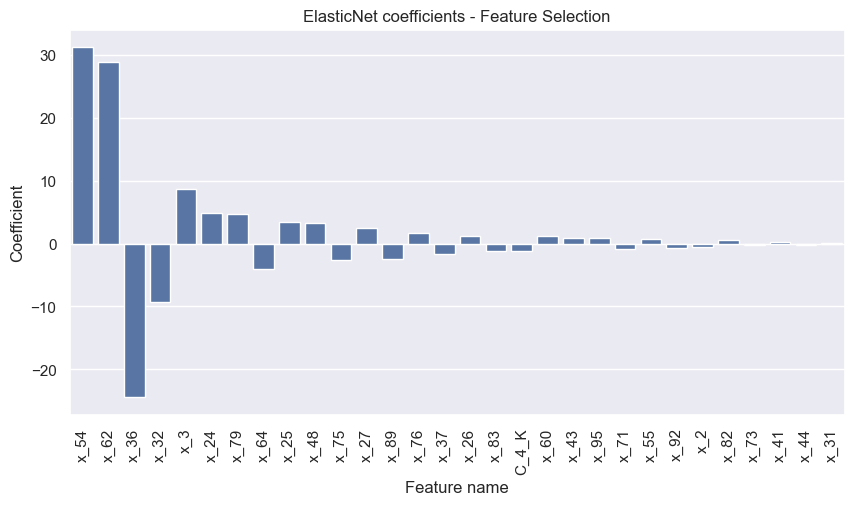

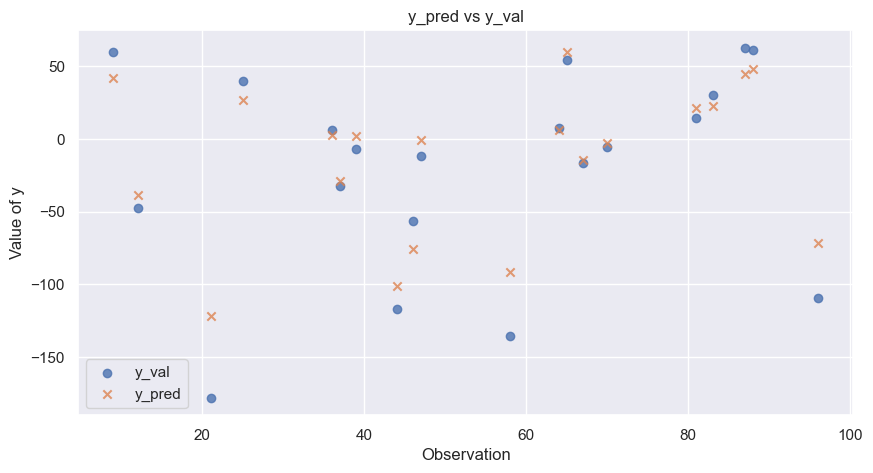

In [40]:
data_encoded = train_preprocessing(data)

X = data_encoded.drop(columns='y')
y = data_encoded.y

best_alpha, best_l1_ratio = model_selection(X, y)

enet, imputer = elastic_net(X, y, best_alpha, best_l1_ratio)

In [68]:
# get mean and std from training data
x_train_mean = X.mean(axis=0)
x_train_std = X.std(axis=0)
x_new = pd.read_csv('case1Data_Xnew.txt', sep=",")
def test_data_preparation(x_new, x_train_mean, x_train_std):
    x_new = x_new.apply(lambda x: x.astype('float64') if 'x' in x.name else x)
    x_new = x_new.apply(lambda x: x.astype('category') if 'C' in x.name else x)
    x_new.columns = x_new.columns.str.replace(' ', '')
    features = [x for x in x_new.columns if x != 'y']   
    features_num = [x for x in x_new.columns if x.startswith('x')]
    categorical_features = x_new[features].select_dtypes(include=['category']).columns

    NaN_array = np.zeros(1000)

    # apply one-hot encoding
    one_hot_encoded = pd.get_dummies(x_new[categorical_features], drop_first=False, dummy_na=False, dtype=int)
    # convert all one-hot encoded columns to int
    one_hot_encoded = one_hot_encoded.astype(int)

    # Drop the original categorical columns from the DataFrame
    df_numerical = x_new.drop(columns=categorical_features)

    # Concatenate the one-hot encoded columns with the original DataFrame
    x_new_encoded = pd.concat([df_numerical, one_hot_encoded], axis=1)
    x_new_encoded.columns = x_new_encoded.columns.str.replace(' ', '')

    # standardize the data
    x_new_encoded.iloc[:, :len(features_num)] = (x_new_encoded.iloc[:, :len(features_num)] - x_train_mean[features_num]) / x_train_std[features_num]
    
    # Impute missing values
    imputer_test = IterativeImputer(max_iter=10, random_state=0)
    x_new_imputed = x_new_encoded.copy()
    x_new_imputed[features_num] = imputer_test.fit_transform(x_new_encoded[features_num])
    
    return x_new_imputed, x_new_encoded

In [71]:
x_new_imputed, x_new_encoded = test_data_preparation(x_new, x_train_mean, x_train_std)
# Predict y for x_new_encoded
y_pred = enet.predict(x_new_imputed)

In [72]:
y_pred = pd.DataFrame(y_pred, columns=['y'])
y_pred.describe()

,y
count,1000.000000
mean,-9.879389
std,47.828452
min,-178.902064
25%,-44.259109
50%,-8.790804
75%,23.259404
max,148.980875


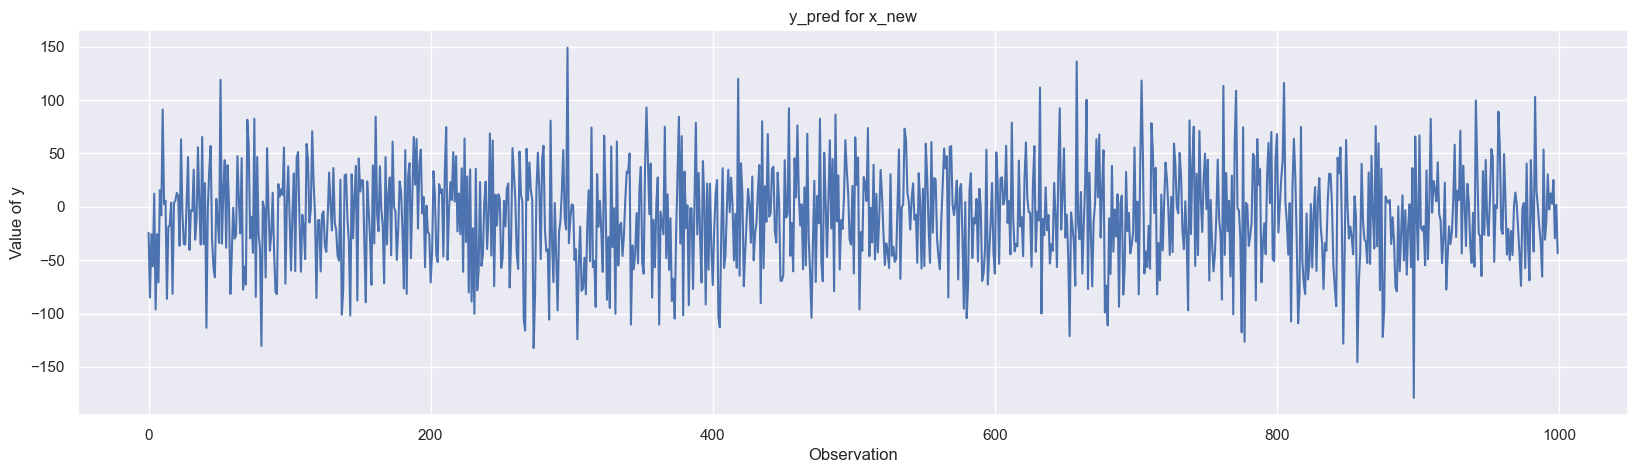

In [73]:
# plot y_pred
plt.figure(figsize=(20, 5))
plt.title("y_pred for x_new")
plt.xlabel("Observation")
plt.ylabel("Value of y")
plt.plot(y_pred)
plt.show()